In [1]:
import numpy as np
import tensorflow as tf
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
# Depending on the classification model use, we might need to import other packages.
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from datasets import DatasetUCI
from envs import LalEnvFirstAccuracy
from helpers import Minibatch, ReplayBuffer
from dqn import DQN
from Test_AL import policy_rl
import matplotlib.pyplot as plt
import random

/home/lazaioan/anaconda3/envs/RLA/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lazaioan/anaconda3/envs/RLA/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lazaioan/anaconda3/envs/RLA/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lazaioan/anaconda3/envs/RLA/lib/python3.6/s

Parameters for dataset and model.

In [2]:
N_STATE_ESTIMATION = 30
SIZE = -1
SUBSET = -1 # -1 for using all data points, 0 for even, 1 for odd.
N_JOBS = 1 # Can set more if we want to parallelise.
# Remove the dataset that will be used for testing.
# ['australian', 'breast_cancer', 'diabetis', 'flare_solar', 'german', 'heart', 'mushrooms', 'waveform', 'wdbc']
# possible_dataset_names = ['breast_cancer', 'diabetis', 'flare_solar', 'german', 'heart', 'mushrooms', 'waveform', 'wdbc']
possible_dataset_names = ['waveform']
test_dataset_names = ['diabetis']
# The quality is measured according to a given quality measure "quality_method". 
QUALITY_METHOD = metrics.accuracy_score

In [3]:
import shutil
import os

cwd = os.getcwd() # Find current directory.

# Delete following directories if they exist.
shutil.rmtree(cwd+'/__pycache__', ignore_errors=True)
shutil.rmtree(cwd+'/agents', ignore_errors=True)
shutil.rmtree(cwd+'/AL_results', ignore_errors=True)
shutil.rmtree(cwd+'/checkpoints', ignore_errors=True)
shutil.rmtree(cwd+'/summaries', ignore_errors=True)

Initialise a dataset that will contain a sample of datapoint from one the indicated classes.

In [4]:
dataset = DatasetUCI(possible_dataset_names, n_state_estimation=N_STATE_ESTIMATION, subset=SUBSET, size=SIZE)
# If we want to measure test error along with training.
dataset_test = DatasetUCI(test_dataset_names, n_state_estimation=N_STATE_ESTIMATION, subset=1, size=SIZE)

In [5]:
model = LogisticRegression(n_jobs=N_JOBS)

Initialise the environment.

In [6]:
env = LalEnvFirstAccuracy(dataset, model, quality_method=QUALITY_METHOD)
env_test = LalEnvFirstAccuracy(dataset_test, model, quality_method=QUALITY_METHOD)
tf.reset_default_graph()

Parameters for training RL.

In [7]:
DIRNAME = './agents/1-australian-logreg-8-to-1/' # The resulting agent of this experiment will be written in a file.

# Replay buffer parameters.
REPLAY_BUFFER_SIZE = 1e4
PRIOROTIZED_REPLAY_EXPONENT = 3

# Agent parameters.
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
TARGET_COPY_FACTOR = 0.01
BIAS_INITIALIZATION = 0 # Default 0 # will be set to minus half of average duration during warm start experiments.

# Warm start parameters.
WARM_START_EPISODES = 100 # Reduce for test.
NN_UPDATES_PER_WARM_START = 25

# Episode simulation parameters.
EPSILON_START = 1
EPSILON_END = 0.1
EPSILON_STEPS = 1000

# Training parameters.
TRAINING_ITERATIONS = 10 # Reduce for test.
TRAINING_EPISODES_PER_ITERATION = 5 # At each training iteration x episodes are simulated.
NN_UPDATES_PER_ITERATION = 5 # At each training iteration x gradient steps are made.

# Validation and test parameters.
N_VALIDATION = 2 # Reduce for test.
N_TEST = 2 # Reduce for test.
VALIDATION_TEST_FREQUENCY = 3 # Every x iterations, val and test are performed.

Initialise replay buffer.

In [8]:
replay_buffer = ReplayBuffer(buffer_size=REPLAY_BUFFER_SIZE, prior_exp=PRIOROTIZED_REPLAY_EXPONENT)

Warm-start the replay buffer with random episodes. 

Collect episodes.

In [9]:
# Keep track of episode duration to compute average.
episode_durations = []
episode_scores = []
episode_number = 1

for _ in range(WARM_START_EPISODES):
    
    print("Episode {}.".format(episode_number))
    # Reset the environment to start a new episode.
    # The classifier_state contains vector representation of state of the environment (depends on the classifier).
    # The next_action_state contains vector representations of all actions available to be taken at the next step.
    classifier_state, next_action_state, reward = env.reset()
    batch = 6
    terminal = False
    episode_duration = 6

    # Before we reach a terminal state, make steps.
    while not terminal:
        # Choose a random action.
        if (batch-2 >= env.n_actions) or (batch+2 >= env.n_actions) or (batch >= env.n_actions):
            terminal = True
        else:
            batch = env._find_batch_size(batch, reward, env.n_actions)

            # Getting numbers from 0 to n_actions.
            inputNumbers =range(0,env.n_actions)

            # Non-repeating using sample() function.
            action = np.array(random.sample(inputNumbers, batch))
            taken_action_state = next_action_state[:,action]
            next_classifier_state, next_action_state, reward, terminal = env.step(action)

            # Store the transition in the replay buffer.
            replay_buffer.store_transition(classifier_state, 
                                        taken_action_state, 
                                        reward, next_classifier_state, 
                                        next_action_state, terminal)
            # Get ready for next step.
            classifier_state = next_classifier_state
            episode_duration += batch

            if terminal:
                episode_final_acc = env.return_episode_qualities()
                episode_scores.append(episode_final_acc[-1])
    # print("Episode {}. | Budget size is {}.".format(episode_number, episode_duration))
    episode_number += 1
    episode_durations.append(episode_duration)

# Compute the average episode duration of episodes generated during the warm start procedure.
av_episode_duration = np.mean(episode_durations)
BIAS_INITIALIZATION = -av_episode_duration/2
print(BIAS_INITIALIZATION)

Episode 1.
Episode 2.
Episode 3.
Episode 4.
Episode 5.
Episode 6.
Episode 7.
Episode 8.
Episode 9.
Episode 10.
Episode 11.
Episode 12.
Episode 13.
Episode 14.
Episode 15.
Episode 16.
Episode 17.
Episode 18.
Episode 19.
Episode 20.
Episode 21.
Episode 22.
Episode 23.
Episode 24.
Episode 25.
Episode 26.
Episode 27.
Episode 28.
Episode 29.
Episode 30.
Episode 31.
Episode 32.
Episode 33.
Episode 34.
Episode 35.
Episode 36.
Episode 37.
Episode 38.
Episode 39.
Episode 40.
Episode 41.
Episode 42.
Episode 43.
Episode 44.
Episode 45.
Episode 46.
Episode 47.
Episode 48.
Episode 49.
Episode 50.
Episode 51.
Episode 52.
Episode 53.
Episode 54.
Episode 55.
Episode 56.
Episode 57.
Episode 58.
Episode 59.
Episode 60.
Episode 61.
Episode 62.
Episode 63.
Episode 64.
Episode 65.
Episode 66.
Episode 67.
Episode 68.
Episode 69.
Episode 70.
Episode 71.
Episode 72.
Episode 73.
Episode 74.
Episode 75.
Episode 76.
Episode 77.
Episode 78.
Episode 79.
Episode 80.
Episode 81.
Episode 82.
Episode 83.
Episode 84.
E

Plots for warm-start episodes.

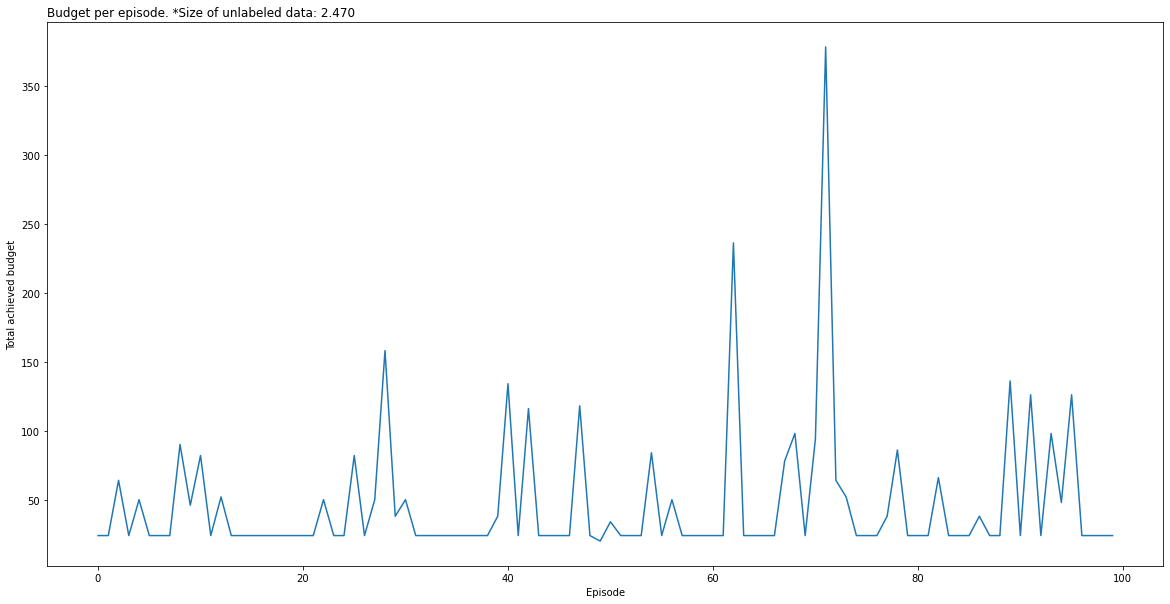

In [10]:
# Plot total budget size per episode.
# Total number of episodes: 100.
xpoints = np.array(range(0,len(episode_durations)))
ypoints = np.array(episode_durations)
plt.figure(figsize=(20,10))
plt.plot(xpoints, ypoints)
plt.title("Budget per episode. *Size of unlabeled data: 2.470", loc = "left")
plt.xlabel("Episode")
plt.ylabel("Total achieved budget")
plt.show()

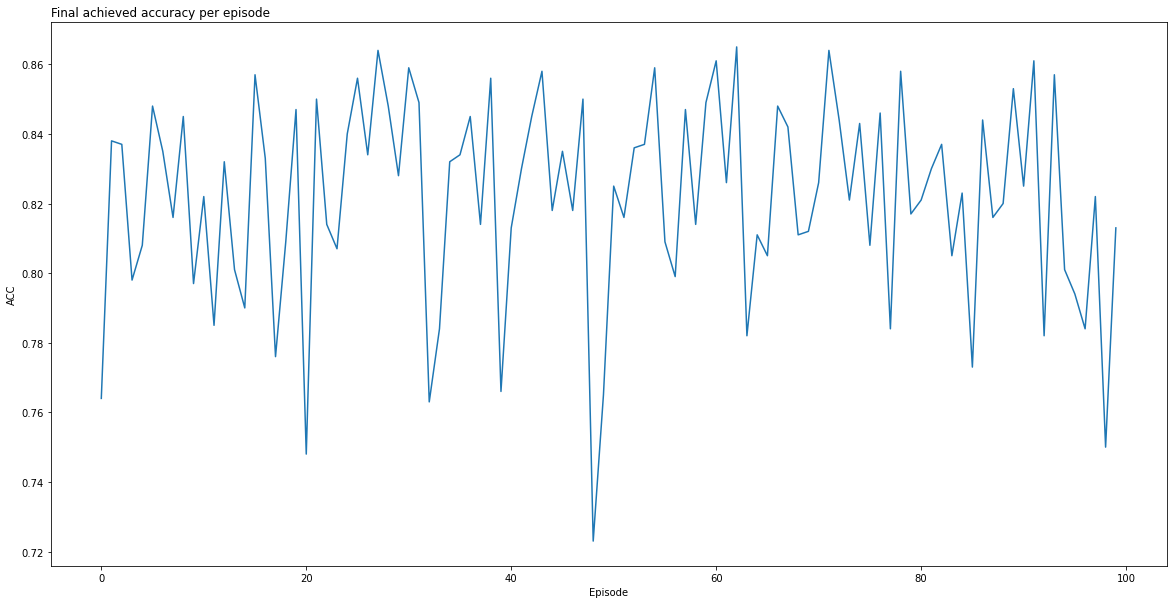

In [11]:
# Plot final achieved accuracy per episode.
# Total number of episodes: 100.
xpoints = np.array(range(0,len(episode_scores)))
ypoints = np.array(episode_scores)
plt.figure(figsize=(20,10))
plt.plot(xpoints, ypoints)
plt.title("Final achieved accuracy per episode", loc = "left")
plt.xlabel("Episode")
plt.ylabel("ACC")
plt.show()

Initialize the DQN agent.

In [ ]:
agent = DQN(experiment_dir=DIRNAME,
            observation_length=N_STATE_ESTIMATION,
            learning_rate=LEARNING_RATE,
            batch_size=BATCH_SIZE,
            target_copy_factor=TARGET_COPY_FACTOR,
            bias_average=BIAS_INITIALIZATION
           )

Do updates of the network based on warm start episodes.

In [ ]:
for _ in range(NN_UPDATES_PER_WARM_START):
    # Sample a batch from the replay buffer proportionally to the probability of sampling.
    print("Compute the minibatch.", "\n")
    minibatch = replay_buffer.sample_minibatch(BATCH_SIZE)

    # Use batch to train an agent. Keep track of temporal difference errors during training.
    print("Train the agent using the minibatch.", "\n")
    td_error = agent.train(minibatch)

    # Update probabilities of sampling each datapoint proportionally to the error.
    print("Update errors.")
    replay_buffer.update_td_errors(td_error, minibatch.indices)

# Train RL

Run multiple training iterations. Each iteration consists of:
- generating episodes following agent's actions with exploration,
- validation and test episodes for evaluating performance,
- Q-network updates.

In [ ]:
train_episode_rewards = []
i_episode = 0

In [ ]:
is_training = True
for iteration in range(TRAINING_ITERATIONS):

    print("ITERATION {}.".format(iteration+1))
    # GENERATE NEW EPISODES
    # Compute epsilon value according to the schedule.
    epsilon = max(EPSILON_END, EPSILON_START-iteration*(EPSILON_START-EPSILON_END)/EPSILON_STEPS)

    # Simulate training episodes.
    episode_number = 1
    
    episode_duration = 6

    for _ in range(TRAINING_EPISODES_PER_ITERATION):

        # Reset the environment to start a new episode.
        classifier_state, next_action_state, reward = env.reset()
        batch = 6
        terminal = False
        episode_duration = 6
        terminal = False

        # Keep track of stats of episode to analyse it in tensorboard.
        episode_reward = 0
        
        # Run an episode.
        while not terminal:
            train_batch = batch
            if (train_batch-2 >= env.n_actions) or (train_batch+2 >= env.n_actions) or (train_batch >= env.n_actions):
                terminal = True
            else:
                train_batch = env._find_batch_size(train_batch, reward, env.n_actions)
                episode_duration += train_batch
                action = agent.get_action(classifier_state, next_action_state, train_batch)

                if np.random.ranf() < epsilon:
                    inputNumbers =range(0,env.n_actions)
                    action = np.array(random.sample(inputNumbers, train_batch))

                # With epsilon probability, take a random action.
                # taken_action_state is a vector that corresponds to a taken action.
                taken_action_state = next_action_state[:,action]

                # Make another step.
                next_classifier_state, next_action_state, reward, terminal = env.step(action)

                # Store a step in replay buffer.
                replay_buffer.store_transition(classifier_state, 
                                            taken_action_state, 
                                            reward, 
                                            next_classifier_state, 
                                            next_action_state, 
                                            terminal)
                
                # Change a state of environment.
                classifier_state = next_classifier_state
        print("Iteration {}. | Episode {}. | Budget size is {}.".format(iteration, episode_number, episode_duration))
        episode_number += 1

    # VALIDATION AND TEST EPISODES.
    episode_summary = tf.Summary()
    if iteration%VALIDATION_TEST_FREQUENCY == 0:

        # Validation episodes are run. Use env for it.
        print("\n\n\n")
        print("Iteration {}. Validation episodes.".format(iteration+1))
        all_durations_validation = []
        for i in range(N_VALIDATION):
            done = False
            state, next_action_state, reward = env.reset()
            validation_batch = batch
            all_durations_validation.append(validation_batch)
            while not(done):
                if (validation_batch-2 >= env.n_actions) or (validation_batch+2 >= env.n_actions) or (validation_batch >= env.n_actions):
                    done = True
                else:
                    validation_batch = env._find_batch_size(validation_batch, reward, env.n_actions)
                    all_durations_validation.append(validation_batch)
                    action = policy_rl(agent, state, next_action_state, validation_batch)        
                    taken_action_state = next_action_state[:,action]
                    next_state, next_action_state, reward, done = env.step(action)
                    state = next_state
        
        # Test episodes are run. Use env_test for it.
        print("\n\n\n")
        print("Iteration {}. Test episodes.".format(iteration+1))
        all_durations_test = []
        for i in range(N_TEST):
            done = False
            state, next_action_state, reward = env_test.reset()
            test_batch = batch
            all_durations_test.append(test_batch)
            while not(done):
                if (test_batch-2 >= env_test.n_actions) or (test_batch+2 >= env_test.n_actions) or (test_batch >= env_test.n_actions):
                    done = True
                else:
                    test_batch = env_test._find_batch_size(test_batch, reward, env_test.n_actions)
                    all_durations_test.append(test_batch)
                    action = policy_rl(agent, state, next_action_state, test_batch)        
                    taken_action_state = next_action_state[:,action]
                    next_state, next_action_state, reward, done = env_test.step(action)
                    state = next_state
   
    # NEURAL NETWORK UPDATES.
    for _ in range(NN_UPDATES_PER_ITERATION):
        minibatch = replay_buffer.sample_minibatch(BATCH_SIZE)
        td_error = agent.train(minibatch)
        replay_buffer.update_td_errors(td_error, minibatch.indices)